Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

Dataset Description:
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000   

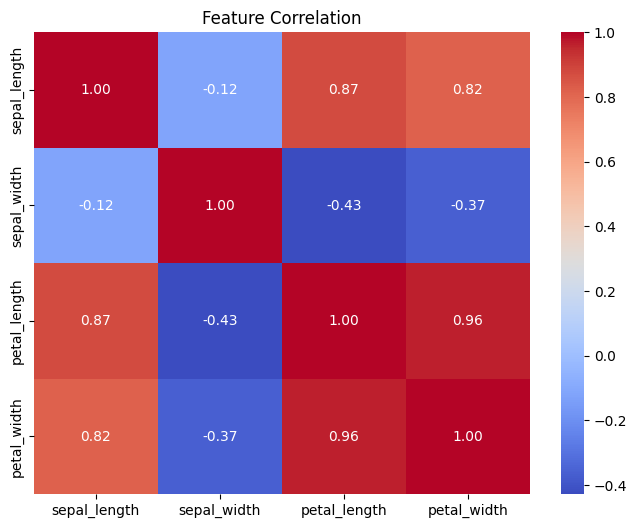


Model Accuracy: 0.9

Classification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.82      0.90      0.86        10
   Virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



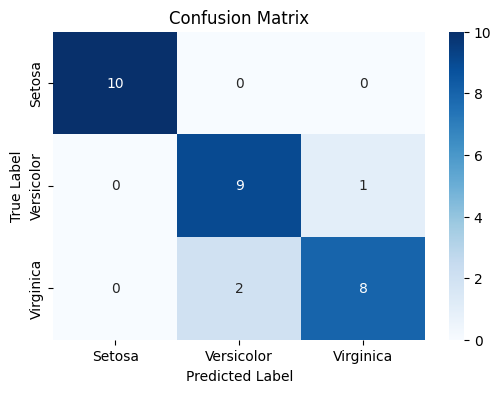

<ipython-input-7-06077b2abeb2>:109: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




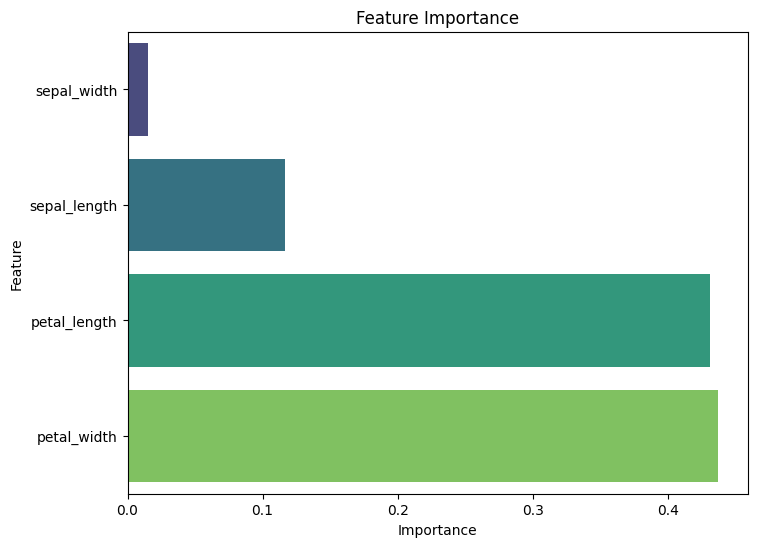

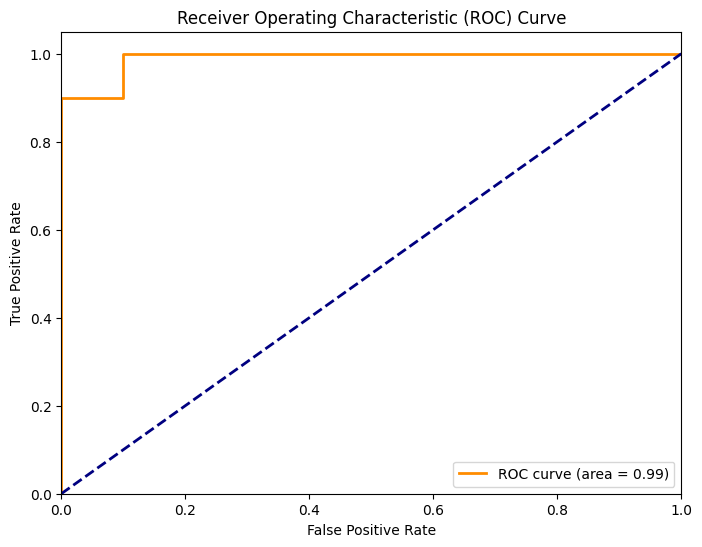

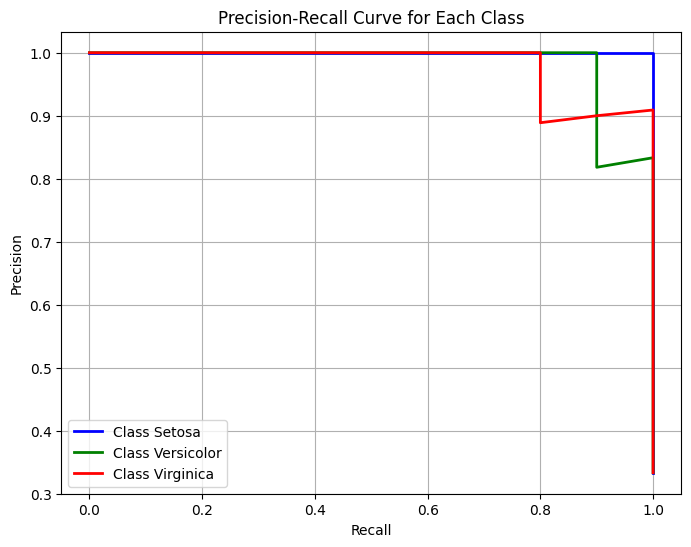

['iris_rf_model.pkl']

In [7]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the Iris dataset
from sklearn.datasets import load_iris
data = load_iris()

# Convert the data to a Pandas DataFrame
iris_df = pd.DataFrame(
    data=np.c_[data['data'], data['target']],
    columns=data['feature_names'] + ['species']
)

# Rename columns for clarity
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Mapping species labels to names
iris_df['species'] = iris_df['species'].map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(iris_df.info())

print("\nDataset Description:")
print(iris_df.describe())

# Check for missing values
print("\nMissing Values:")
print(iris_df.isnull().sum())

# Interactive Pairplot using Plotly for better visualization
fig = px.scatter_matrix(iris_df, dimensions=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
                        color='species',
                        title="Iris Flower Pairplot",
                        labels={'species': 'Species'})
fig.update_traces(diagonal_visible=False)
fig.show()

# Correlation heatmap (excluding the species column)
plt.figure(figsize=(8, 6))
sns.heatmap(iris_df.drop(columns=['species']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')
plt.show()

# Splitting the dataset
X = iris_df.drop(columns=['species'])
y = iris_df['species']

# Encoding target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix (using a heatmap)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importance visualization (sorted with a horizontal bar plot)
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the feature importance values
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# ROC Curve (Receiver Operating Characteristic curve)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for Multiclass Classification
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass classification (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Binary matrix of true values
y_pred_prob = rf_model.predict_proba(X_test)  # Get probabilities for each class

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, color=colors[i], lw=2, label=f'Class {le.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Save the model for future use
joblib.dump(rf_model, 'iris_rf_model.pkl')
